<a href="https://colab.research.google.com/github/Junseokee/Deep_Learning/blob/main/220907_Yolo%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리

In [1]:
from google.colab import drive
import os
import json
from tqdm import tqdm
import shutil
import re
from glob import glob
from google.colab import files

# 데이터셋 다운로드

In [2]:
drive.mount('/content/drive')


MessageError: ignored

In [30]:
%cd /content/drive/MyDrive/trash
!pwd

/content/drive/MyDrive/trash
/content/drive/MyDrive/trash


In [ ]:
# yolov5 모델 다운로드
#!git clone https://github.com/ultralytics/yolov5.git

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [31]:
%cd yolov5
#!pip install -r requirements.txt

/content/drive/MyDrive/trash/yolov5


In [28]:
import yaml
import torch
from IPython.display import Image, clear_output

In [32]:
#%mkdir /content/drive/MyDrive/trash/yolov5/
!pwd

/content/drive/.shortcut-targets-by-id/1rY4Lus-zzKoN8RwQxfYsO6dlyfhhe2rL/trash/yolov5


In [ ]:
# %mkdir ./img
# %mkdir ./label

# **데이터 셋 준비**


In [33]:
from glob import glob

train_img_lst = glob('/content/drive/MyDrive/trash/yolov5/dataset/images/*.jpg')
with open('/content/drive/MyDrive/trash/yolov5/dataset/train.txt','w') as f:
  f.write('\n'.join(train_img_lst)+'\n')

In [34]:
len(train_img_lst)

1760

In [35]:
from IPython.core.magic import register_line_cell_magic

# register_line_cell_magic을 이용해 IPython에서 바로 사용할 수 있게 정의
# writetimplate를 쉽게 사용할 수 있음
@register_line_cell_magic
def writetemplate(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

In [63]:
%%writetemplate /content/drive/MyDrive/trash/yolov5/dataset/data.yaml

train: ./dataset/images
val: ./dataset/images

nc: 7
names:
  0: 'polygon'
  1: 'styrofoam'
  2: 'glass'
  3: 'metal'
  4: 'pet_bottle'
  5: 'buoy'
  6: 'etc'

In [64]:
%cat /content/drive/MyDrive/trash/yolov5/dataset/data.yaml


train: ./dataset/images
val: ./dataset/images

nc: 7
names:
  0: 'polygon'
  1: 'styrofoam'
  2: 'glass'
  3: 'metal'
  4: 'pet_bottle'
  5: 'buoy'
  6: 'etc'


In [65]:
import yaml
with open('/content/drive/MyDrive/trash/yolov5/dataset/data.yaml', 'r') as stream:
  num_classes=str(yaml.safe_load(stream)['nc'])

  print(num_classes)

7


In [52]:
!cat /content/drive/.shortcut-targets-by-id/1rY4Lus-zzKoN8RwQxfYsO6dlyfhhe2rL/trash/yolov5/models/yolov5s.yaml


# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 7  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [53]:
%%writetemplate /content/drive/.shortcut-targets-by-id/1rY4Lus-zzKoN8RwQxfYsO6dlyfhhe2rL/trash/yolov5/models/custom_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [56]:
!pwd

/content/drive/.shortcut-targets-by-id/1rY4Lus-zzKoN8RwQxfYsO6dlyfhhe2rL/trash/yolov5


In [67]:
# 데이터 학습
!python train.py --img 640 --batch 32 --epochs 5 --data ./dataset/data.yaml --cfg ./models/custom_yolov5s.yaml --weight '' --name ocean_results --cache

train: weights=, cfg=./models/custom_yolov5s.yaml, data=./dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=ocean_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.2-94-g1aea74c Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, c

In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1rY4Lus-zzKoN8RwQxfYsO6dlyfhhe2rL/trash/yolov5


In [ ]:
%ls

classify/        export.py   ocean/            runs/           utils/
CONTRIBUTING.md  hubconf.py  __pycache__/      setup.cfg       val.py
data/            LICENSE     README.md         train.py
detect.py        models/     requirements.txt  tutorial.ipynb


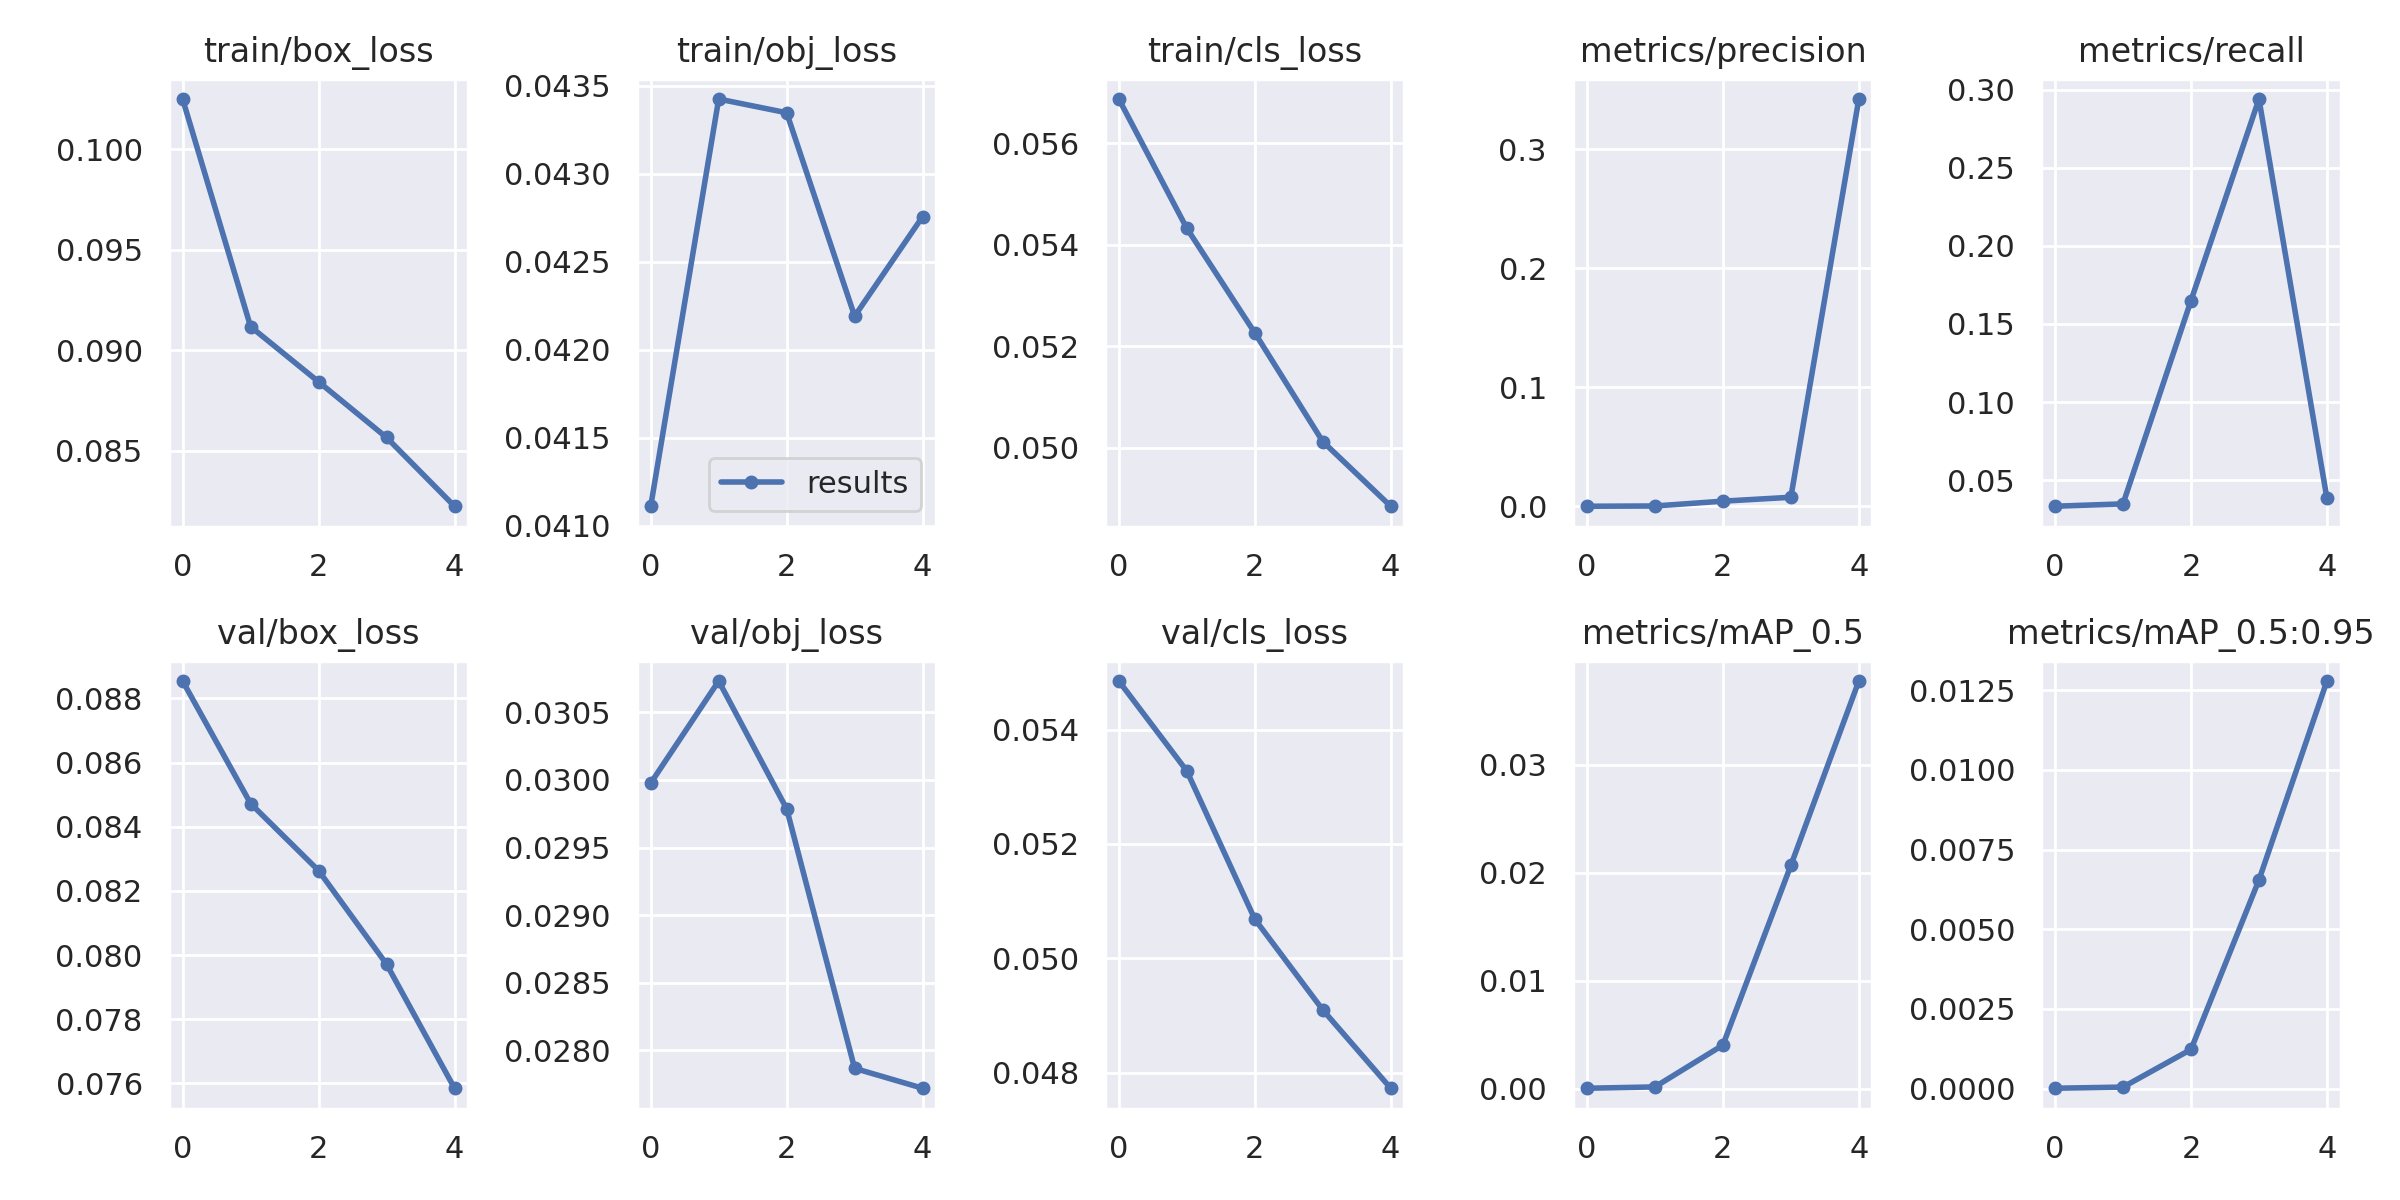

In [70]:
Image(filename='/content/drive/MyDrive/trash/yolov5/runs/train/ocean_results14/results.png', width=800)

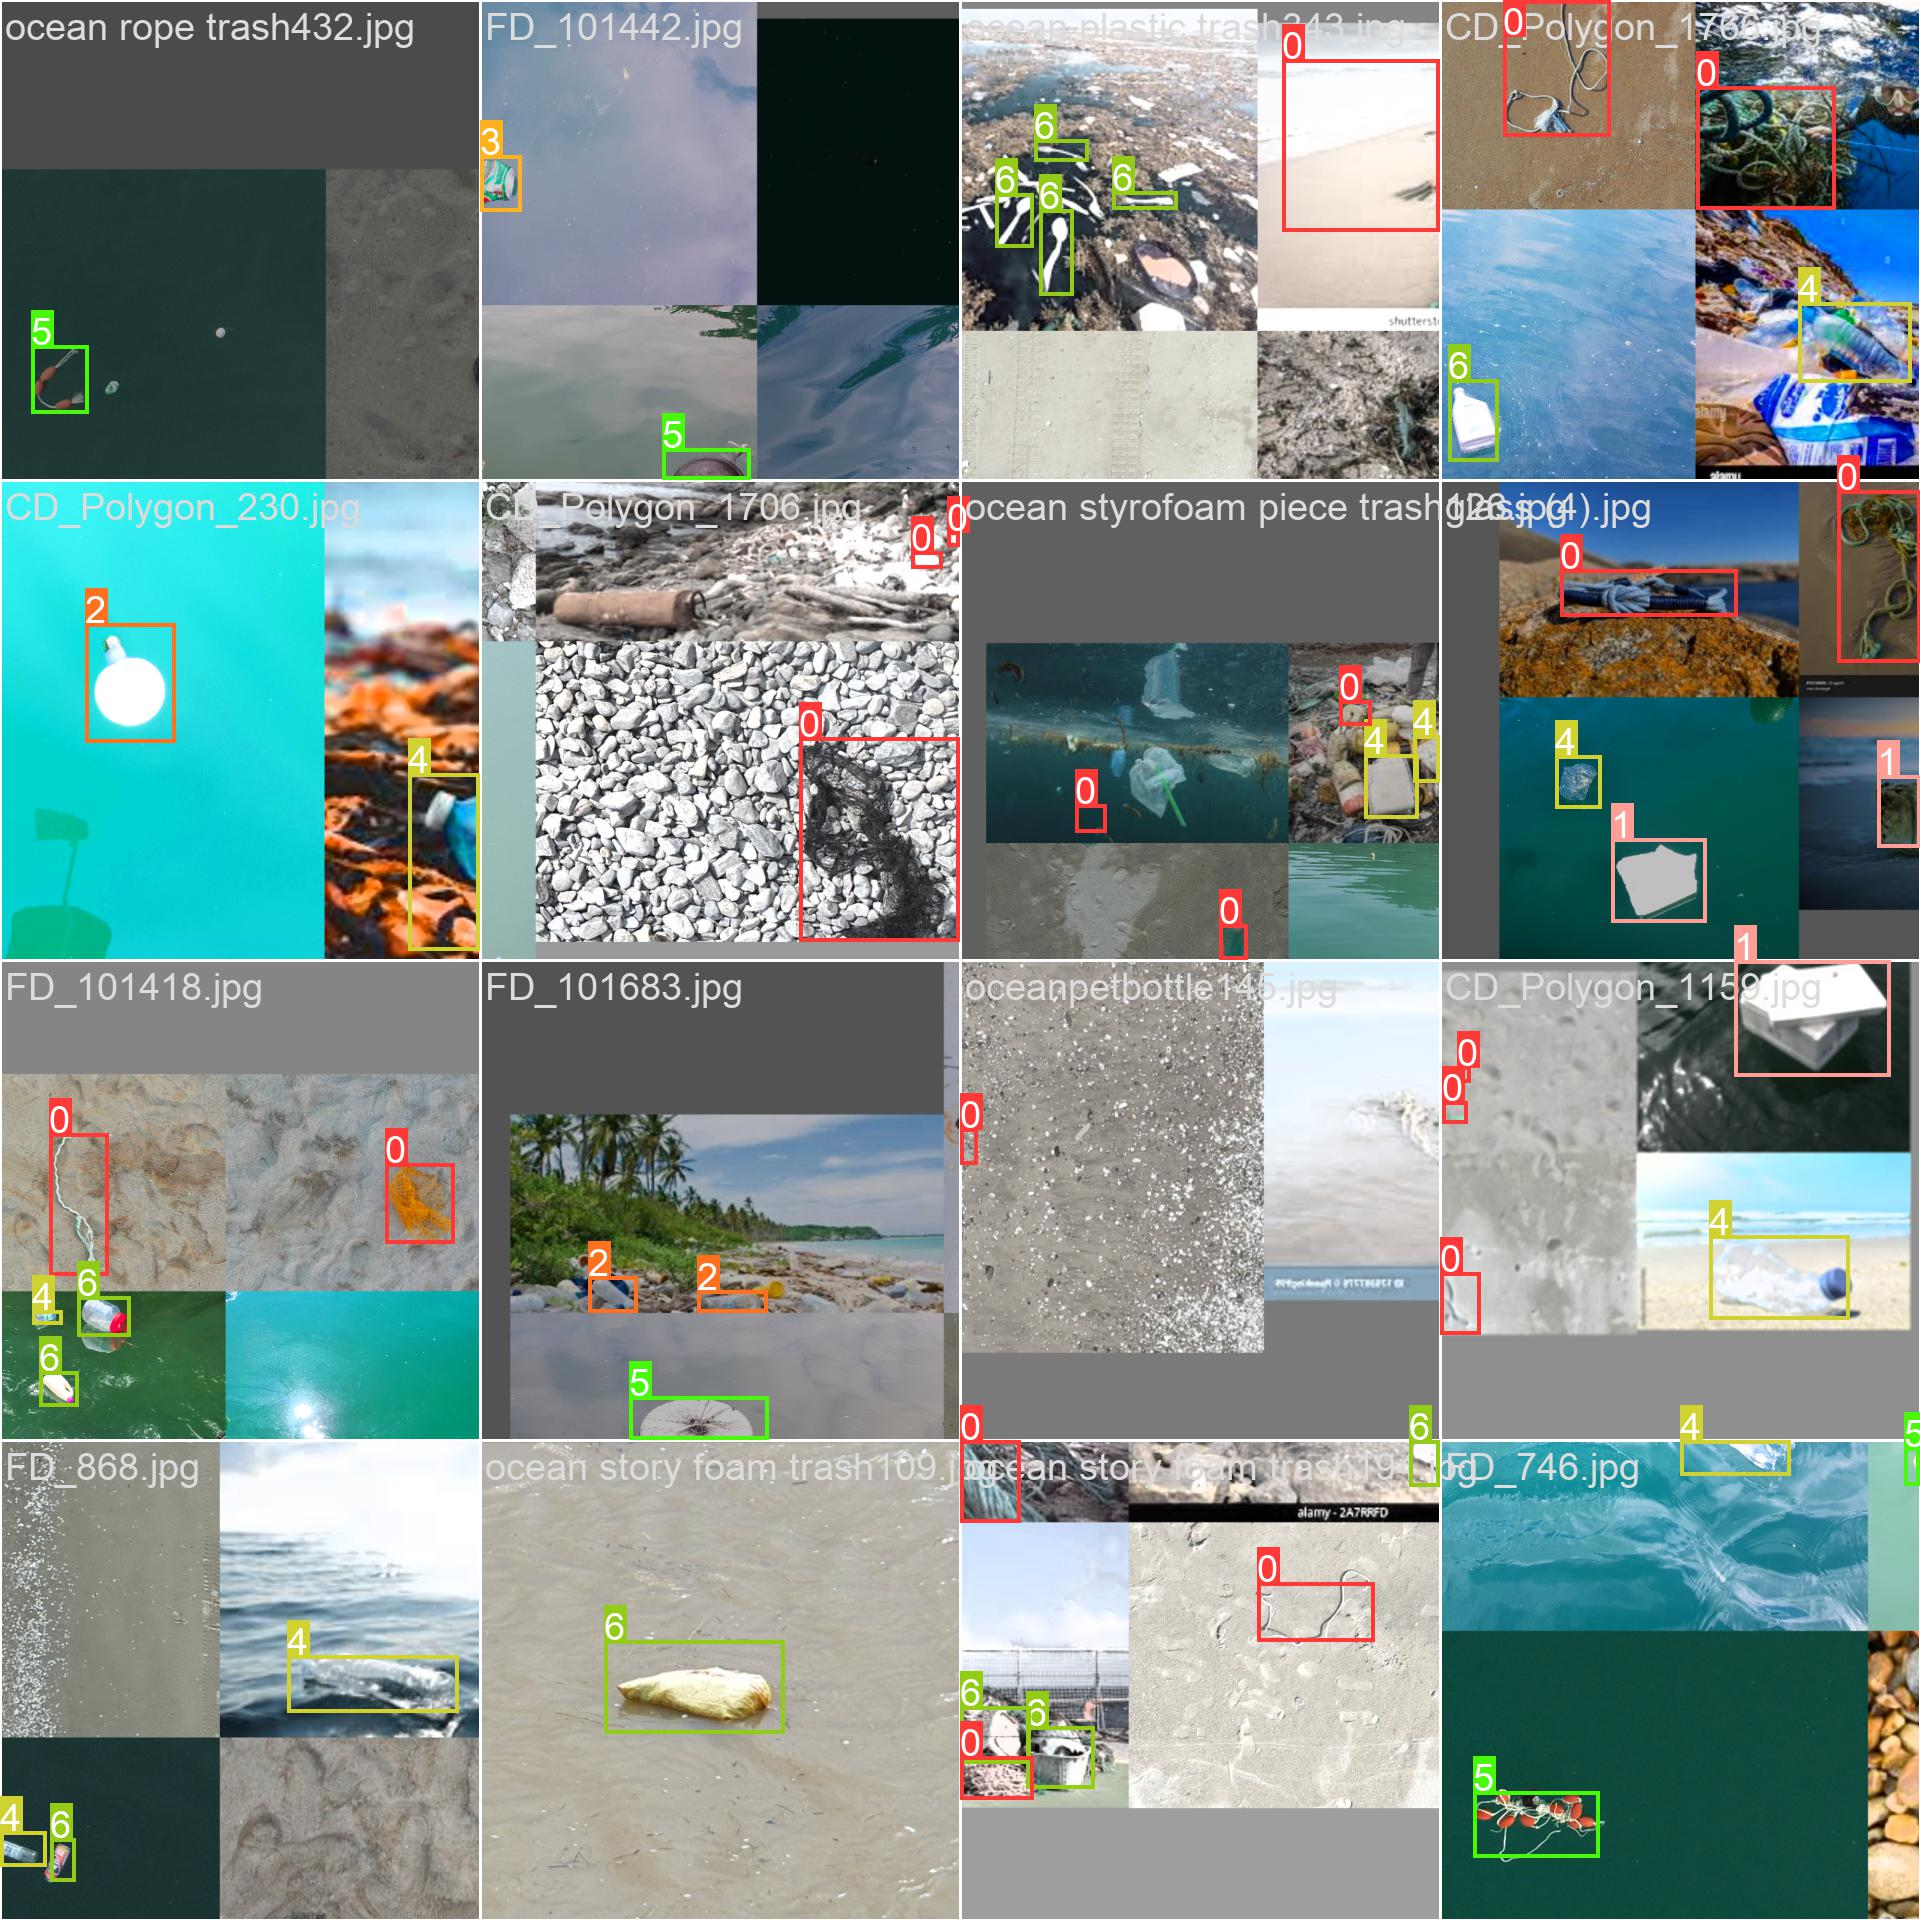

In [71]:
# 디텍팅 확인
Image(filename='/content/drive/MyDrive/trash/yolov5/runs/train/ocean_results14/train_batch0.jpg', width=800)

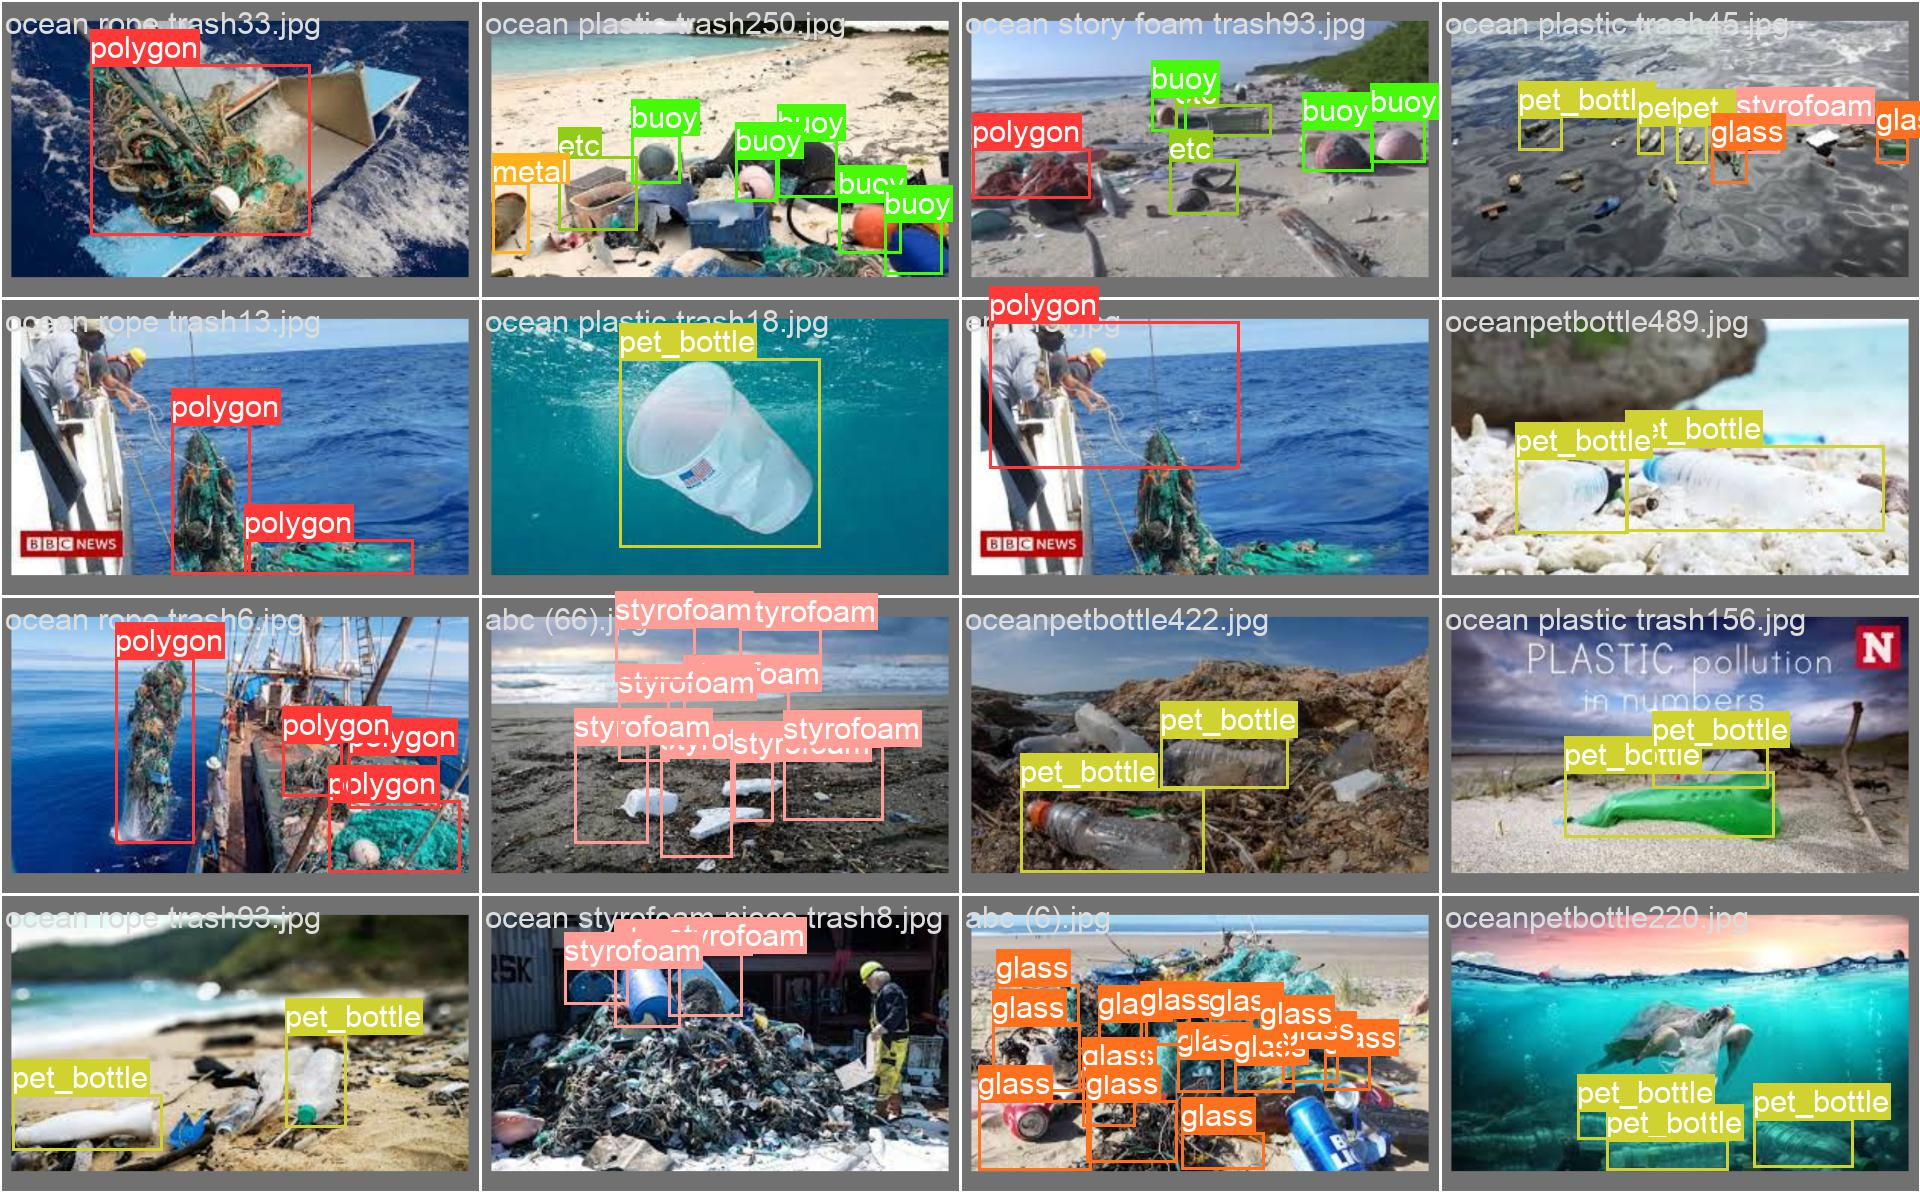

In [73]:
# 라벨값 확인
Image(filename='/content/drive/MyDrive/trash/yolov5/runs/train/ocean_results14/val_batch1_labels.jpg', width=800)